# Generating single-cell representations from highly multiplexed images and integration with PyTorch

This notebook illustrates how single-cell representations can be generated from highly multiplexed images (scales to terapixel-scale images ). These representations can then be used downstream to train classifiers in PyTorch.

Please also see this [notebook](../general/Featurize_with_kronos.ipynb), which demonstrates how to extract deep features from single-cell representations using a pretrained model. This is useful if you are not interested in working with the single-cell instances directly and only want to featurize them.

## Read the data

In [1]:
import os
from tempfile import tempdir

import harpy as hp
from spatialdata import read_zarr

sdata = hp.datasets.codex_example()

output_dir = tempdir
# output_dir = "/data/groups/technologies/spatial.catalyst/Arne/benchmark_harpy/codex_data"

# back to zarr
output_path = os.path.join(output_dir, "sdata_codex.zarr")
sdata.write(output_path, overwrite=False)
sdata = read_zarr(output_path)

/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_1_6_26/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
sdata

SpatialData object, with associated Zarr store: /data/groups/technologies/spatial.catalyst/Arne/benchmark_harpy/codex_data/sdata_codex.zarr
├── Images
│     └── 'image': DataTree[cyx] (49, 8011, 8085), (49, 4005, 4042), (49, 2002, 2021), (49, 1001, 1010), (49, 500, 505)
├── Labels
│     └── 'segmentation_mask': DataTree[yx] (8011, 8085), (4005, 4042), (2002, 2021), (1001, 1010), (500, 505)
└── Tables
      ├── 'table_intensities': AnnData (152815, 49)
      └── 'table_intensities_normalized': AnnData (152815, 49)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), segmentation_mask (Labels)

## Extract single cell instances

We use `harpy.tb.extract_instances` to cut out a centered `y`/`x` window around each non-zero label in the segmentation mask (and the matching image crop). The window size is controlled by `diameter`, while `depth` sets the overlap used by `dask.array.map_overlap` (default: `diameter // 2 + 1`).

Set `remove_background=True` to zero everything outside the instance label within each window, or `False` to keep the full window content. If `zarr_output_path` is provided, the extraction is computed immediately and written to disk as Zarr; otherwise a lazy Dask array is returned.

The function returns a 2-tuple `(instance_ids, instances)`, where `instance_ids` contains the label ids and `instances` is either a single Dask array or `(mask_instances, image_instances)` when `extract_mask=True`. The returned Dask array has shape `(i, c, z, y, x)`.

The function is optimized with Dask and scales to terapixel-scale images (e.g., `c=100`, `y=100_000`, `x=100_000`).

In [5]:
import os
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit="48GB",
    local_directory=os.environ.get("TMPDIR"),
)
client = Client(cluster)
print(client.dashboard_link)

# On macOS with 12 logical CPUs, this takes ~1 minute.
# on CentOS with 16 logical CPUs, this takes ~1minute 30 seconds.
instance_ids, out = hp.tb.extract_instances(
    sdata,
    img_layer="image",
    labels_layer="segmentation_mask",
    diameter=64,
    batch_size=500,
    zarr_output_path=output_dir,
    name_instances_image="instances_image.zarr",
    name_instances_mask="instances_mask.zarr",
    extract_mask=True,
    remove_background=True,
    overwrite=True,
)

client.close()

http://127.0.0.1:8787/status


2026-01-13 20:59:40.732 | INFO     | harpy.utils._featurize:__init__:94 - Calculating unique labels in the mask.
2026-01-13 20:59:43.647 | INFO     | harpy.utils._featurize:__init__:97 - Finished calculating unique labels in the mask.
2026-01-13 20:59:43.649 | INFO     | harpy.utils._featurize:extract_instances:794 - Calculating center of mass for each instance.
/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_1_6_26/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/data/groups/technologies/spatial.catalyst/Arne/harpy/.venv_harpy_1_6_26/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://

## Visualize the extracted instances:

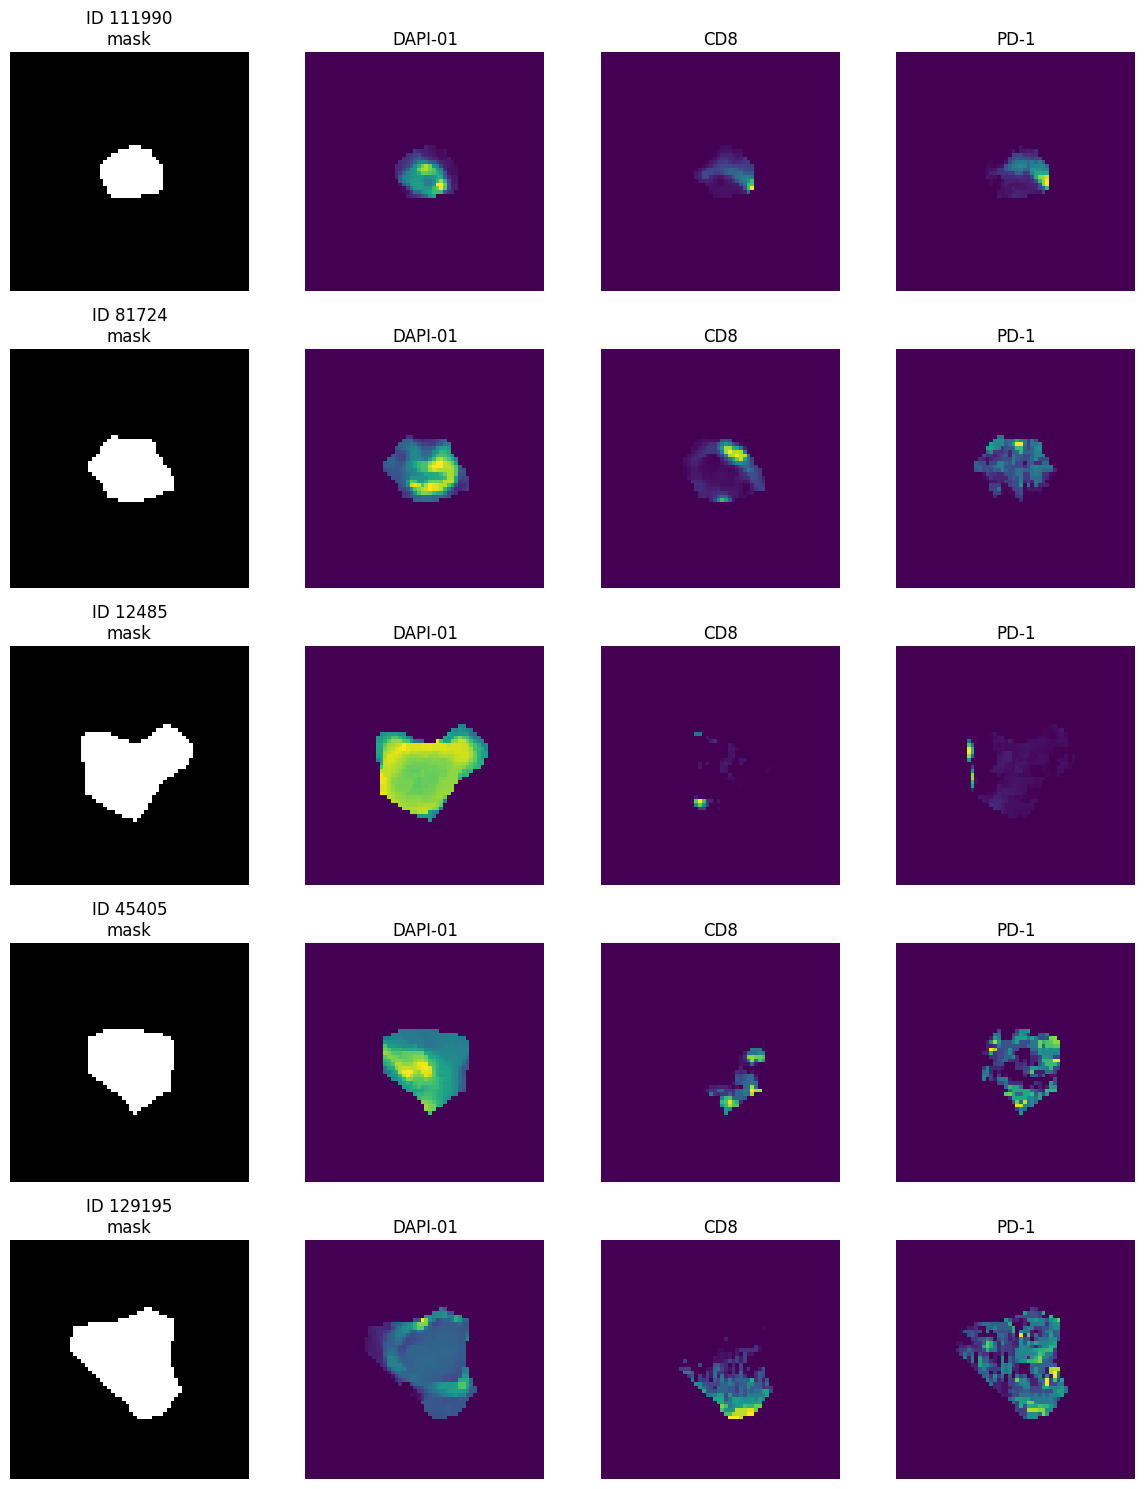

In [7]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

channel_names = hp.im.get_dataarray(sdata, layer="image").c.data.tolist()

mask_instances, image_instances = out

channels_to_plot = ["DAPI-01", "CD8", "PD-1"]  # choose by name
z_slice = 0
n_instances = 5

channel_to_index = {name: i for i, name in enumerate(channel_names)}

channel_indices = []
for ch in channels_to_plot:
    if ch not in channel_to_index:
        raise ValueError(f"Channel '{ch}' not found.")
    channel_indices.append(channel_to_index[ch])

rng = np.random.default_rng(seed=0)
rand_idx = rng.choice(len(instance_ids), size=n_instances, replace=False)

n_cols = 1 + len(channel_indices)

fig, axes = plt.subplots(
    n_instances,
    n_cols,
    figsize=(3 * n_cols, 3 * n_instances),
    squeeze=False,
)

for row, i in enumerate(rand_idx):
    instance_id = instance_ids[i]
    ax = axes[row, 0]
    mask = mask_instances[i, 0, z_slice]
    ax.imshow(mask, cmap="gray")
    ax.set_title(f"ID {instance_id}\nmask")
    ax.axis("off")

    for col, (ch_idx, ch_name) in enumerate(zip(channel_indices, channels_to_plot, strict=False), start=1):
        ax = axes[row, col]
        img = image_instances[i, ch_idx, z_slice]

        img = (img - img.min()) / (da.ptp(img) + 1e-8)

        ax.imshow(img, cmap="viridis")
        ax.set_title(ch_name)
        ax.axis("off")

plt.tight_layout()
plt.show()

Our dataset is annotated, we can use these annotations to train a classification model.

In [ ]:
cells_df = sdata["table_intensities"].obs
cells_df.head()

,cell_ID,fov_labels,x_center,y_center,cell_type,cell_type_id,kronos
cells,,,,,,,
1_segmentation_mask_3314222a,1,segmentation_mask,75.0,2.0,B,0.0,10
2_segmentation_mask_3314222a,2,segmentation_mask,1767.0,2.0,DC,3.0,7
3_segmentation_mask_3314222a,3,segmentation_mask,2545.0,2.0,NK,11.0,7
4_segmentation_mask_3314222a,4,segmentation_mask,2899.0,3.0,Monocyte,10.0,7
5_segmentation_mask_3314222a,5,segmentation_mask,3657.0,3.0,CD4,1.0,7


## Create PyTorch dataloaders

For streaming from large Zarr stores, we provide `harpy.tb.ZarrIterableInstances`, a chunk-wise `IterableDataset`. It iterates chunk by chunk, supports deterministic chunk shuffling per epoch (and inter-chunk shuffling), and partitions work across DDP ranks and DataLoader workers.

Provide `instance_ids` aligned with the `i` dimension of the Zarr store containing the extracted instances (dimensions: `i, c, z, diameter, diameter`), and optionally `labels` for supervised training. Each sample yields `(x, y)` or `(x, y, instance_id, row_idx)` for supervised runs, and `(x, instance_id, row_idx)` for inference.

We can control shuffling (`shuffle_chunks`, `shuffle_within_chunk`), normalization (`normalize`), and output dtype (`x_dtype`).

In [5]:
import pandas as pd
import numpy as np


def _make_instanceid_to_label(df: pd.DataFrame, label_col: str = "cell_type_id", instance_key: str = "cell_ID"):
    """
    Build dict: instance_id (int) -> label (int in [0..15])

    Supports:
      - df has a numeric column named 'cell_ID'
    """
    df2 = df.loc[~df[label_col].isna(), [instance_key, label_col]]

    if instance_key in df2.columns:
        inst = df2[instance_key].astype(int).to_numpy()
    else:
        raise ValueError(f"'{instance_key}' column not found.")

    if df2[instance_key].duplicated().any():
        dup = df2.loc[df2[instance_key].duplicated(), instance_key].iloc[0]
        raise ValueError(f"Duplicate {instance_key} found (e.g. {dup}). This is not allowed.")

    # Ensure labels are int (Categorical -> codes or int cast)
    y = df2[label_col]
    if str(y.dtype) == "category":
        # if categories are already 0..15, codes should match; otherwise cast values
        # safer: cast values to int if they are numeric categories
        try:
            y_int = y.astype(float).astype(int).to_numpy()
        except Exception:  # noqa: BLE001
            y_int = y.cat.codes.to_numpy().astype(int)
    else:
        y_int = y.astype(int).to_numpy()

    # sanity checks
    uniq = np.unique(y_int)

    # no negative labels
    assert uniq.min() >= 0, f"Labels must be >= 0. Found min label {uniq.min()}."

    # contiguous 0..K-1
    expected = np.arange(uniq.size, dtype=uniq.dtype)
    assert np.array_equal(uniq, expected), f"Labels must be contiguous [0..{uniq.size - 1}], but found {uniq.tolist()}."

    return dict(zip(inst, y_int, strict=True))

First, we create a 1D labels array aligned to the i (instance) axis of the Zarr store

In [6]:
from harpy.utils._keys import _INSTANCE_KEY

labels_df = cells_df
label_col = "cell_type_id"
instance_key = _INSTANCE_KEY

inst2lab = _make_instanceid_to_label(labels_df, label_col=label_col, instance_key=instance_key)

labels = np.full((len(instance_ids),), -1, dtype=np.int64)
for i, inst_id in enumerate(instance_ids):
    labels[i] = inst2lab.get(int(inst_id), -1)  # set to -1 if no matching labels found

In [7]:
labels

array([ 0,  3,  6, ..., -1, 12,  8], shape=(152815,))

In the DataLoaders introduced below, shuffling is performed at two levels for each epoch: first, the chunks along the instance dimension are shuffled, and second, samples within each chunk are shuffled. While this strategy is efficient and works well in many cases, it may lead to suboptimal convergence if the spatial chunks are too small, since individual batches may then contain only a limited subset of cell types. In such situations, we recommend performing a full shuffle of the Zarr array on disk prior to training.

In [18]:
import torch

from harpy.table import ZarrIterableInstances, ZarrDataLoader
from torch.utils.data import DataLoader


def _get_default_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# create this iter_ds instance to get the allowed chunk indices.
iter_ds = ZarrIterableInstances(
    zarr_path=os.path.join(output_dir, "instances_image.zarr"),
    instance_ids=instance_ids,
    labels=labels,  # aligned to
    shuffle_chunks=True,
    chunk_seed=0,  # fixed seed for reproducibility
    shuffle_within_chunk=True,
    buffer_seed=0,  # set for deterministic within-chunk shuffle, but each epoch different shuffle
    normalize="minmax01",
    x_dtype=torch.float32,
    return_instance_id=False,
    return_row_index=False,
    allowed_chunk_indexes=None,
)

# train-test split
chunks = iter_ds.valid_chunk_indexes.copy()
rng = np.random.default_rng(0)
rng.shuffle(chunks)
cut = int(0.8 * len(chunks))
train_chunks, test_chunks = chunks[:cut], chunks[cut:]


train_iter = ZarrIterableInstances(
    zarr_path=os.path.join(output_dir, "instances_image.zarr"),
    instance_ids=instance_ids,
    labels=labels,  # aligned to rows
    shuffle_chunks=True,
    chunk_seed=0,  # fixed seed for reproducibility
    shuffle_within_chunk=True,
    buffer_seed=0,  # set for deterministic within-chunk shuffle, but each epoch different shuffle
    normalize="minmax01",
    x_dtype=torch.float32,
    return_instance_id=False,
    return_row_index=False,
    allowed_chunk_indexes=train_chunks,
)


test_iter = ZarrIterableInstances(
    zarr_path=os.path.join(output_dir, "instances_image.zarr"),
    instance_ids=instance_ids,
    labels=labels,  # aligned to rows
    shuffle_chunks=False,  # will be ignored
    chunk_seed=0,
    shuffle_within_chunk=False,
    buffer_seed=0,
    normalize="minmax01",
    x_dtype=torch.float32,
    return_instance_id=False,
    return_row_index=False,
    allowed_chunk_indexes=test_chunks,
)

device = _get_default_device()

print("Using device:", device)

train_loader = ZarrDataLoader(
    dataset=train_iter,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=(device.type == "cuda"),
    persistent_workers=True,
    prefetch_factor=4,
    start_epoch=0,
)

test_loader = DataLoader(  # do not increase epoch index if run on test_loader
    dataset=test_iter,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=(device.type == "cuda"),
    persistent_workers=True,
    prefetch_factor=4,
)

Using device: cuda


## Train a (dummy) classification model

We now train a lightweight classification model to illustrate the end-to-end workflow. This model is intentionally simple and meant only for demonstration; for real applications, use a stronger architecture and pretrained weights.


In [ ]:
from tqdm import tqdm

import torch
import torch.nn as nn


class SmallCNN(nn.Module):
    """Small CNN"""

    def __init__(self, in_ch: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 -> 32
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),  # (i,256,1,1)
            nn.Flatten(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        """Forward pass"""
        return self.net(x)


in_ch = len(hp.im.get_dataarray(sdata, layer="image").c.data)
num_classes = len(cells_df[label_col].cat.categories)

model = SmallCNN(in_ch=in_ch, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


def train_one_epoch(model, loader, optimizer, criterion, device):
    """Train"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc="Train", leave=False):
        x, y = batch[0], batch[1]
        if x.ndim == 5:
            x = x.squeeze(2)  # squeeze the z dimension

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Test"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc="Eval", leave=False):
        x, y = batch[0], batch[1]
        if x.ndim == 5:
            x = x.squeeze(2)

        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


epochs = 5
for epoch in range(0, epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    assert train_loader._epoch == epoch + 1

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
        f"test loss {test_loss:.4f} acc {test_acc:.3f}"
    )

Train:   0%|          | 0/895 [00:00<?, ?it/s]

Epoch 00 | train loss 1.9993 acc 0.364 | test loss 1.9636 acc 0.379


Epoch 01 | train loss 1.6267 acc 0.479 | test loss 1.6860 acc 0.458


Epoch 02 | train loss 1.4664 acc 0.529 | test loss 1.5073 acc 0.510


Epoch 03 | train loss 1.3687 acc 0.556 | test loss 1.5420 acc 0.507


Epoch 04 | train loss 1.2940 acc 0.578 | test loss 1.3518 acc 0.566
